# User Manual – Yang Group Project: Fraud Detection with Polynomial SVM

## Environment & Setup
- Python 3.11
- Required packages:
  - `pandas`, `numpy`, `matplotlib`
  - `scikit-learn`, `imbalanced-learn`

## Files Required
- `X_train.csv`, `y_train.csv`
- `X_test.csv`, `y_test.csv`

## How to Run
1. Run each cell from top to bottom.
2. The notebook builds and evaluates four SVM-based models:
   - Baseline SVM
   - SVM with `class_weight='balanced'`
   - SVM + SMOTE oversampling
   - SVM + ADASYN oversampling
3. For each model, the following metrics are displayed:
   - Classification report
   - Confusion matrix
   - Precision-Recall (PR) Curve

## Outputs
- Performance metrics for each model
- PR Curve for **class = 1** (fraud)

## Notes
- To reduce runtime, training is performed on a **subset of 4,000 samples**.
- Final evaluation uses a **test set of 10,000 samples** to confirm ADASYN performance.
- PR Curve is used instead of ROC because this is a highly imbalanced classification problem.
- Fraud = 1, Not Fraud = 0.

### Step 1: Import necessary libraries

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, ADASYN

### Step 2: Load Training and Test Data

In [28]:
# Read in pre-split training and test datasets from CSV files
X_train_full = pd.read_csv("X_train.csv")
y_train_full = pd.read_csv("y_train.csv").values.ravel()
X_test_full = pd.read_csv("X_test.csv")
y_test_full = pd.read_csv("y_test.csv").values.ravel()

# Print original shape
print("Original:", X_train_full.shape, X_test_full.shape)

Original: (750000, 47) (250000, 47)


### Step 3: Take a Small Sample
To speed up model development and testing, we sample a smaller subset from the full dataset.  
We use stratified sampling to preserve the original class distribution (fraud vs. non-fraud).

In [29]:
# Take 4,000 training samples with stratified class distribution
X_train_small, _, y_train_small, _ = train_test_split(
    X_train_full, y_train_full, train_size=4000, stratify=y_train_full, random_state=42)

# Take 1,000 test samples with stratified class distribution
X_test_small, _, y_test_small, _ = train_test_split(
    X_test_full, y_test_full, train_size=1000, stratify=y_test_full, random_state=42)

print("Small subset:", X_train_small.shape, X_test_small.shape)

Small subset: (4000, 47) (1000, 47)


### Step 4: Define Evaluation Function

In [30]:
# Reusable function that outputs classification report, confusion matrix, and PR curve for the fraud class (label = 1)
def evaluate(model, X_train, y_train, X_test, y_test, title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:, 1]

    print(f"=== {title} ===")
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Non-Fraud", "Fraud"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_score)
    ap = average_precision_score(y_test, y_score)
    plt.plot(recall, precision, label=f"{title} (AP={ap:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("PR Curve for Class = 1 (Fraud)")
    plt.legend()
    plt.grid(True)
    plt.show()

### Step 5: Baseline SVM Model

=== Baseline SVM ===
              precision    recall  f1-score   support

           0     0.9899    0.9869    0.9884       989
           1     0.0714    0.0909    0.0800        11

    accuracy                         0.9770      1000
   macro avg     0.5306    0.5389    0.5342      1000
weighted avg     0.9798    0.9770    0.9784      1000



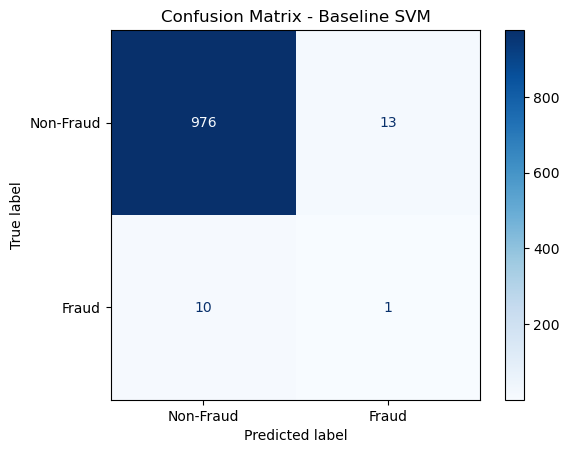

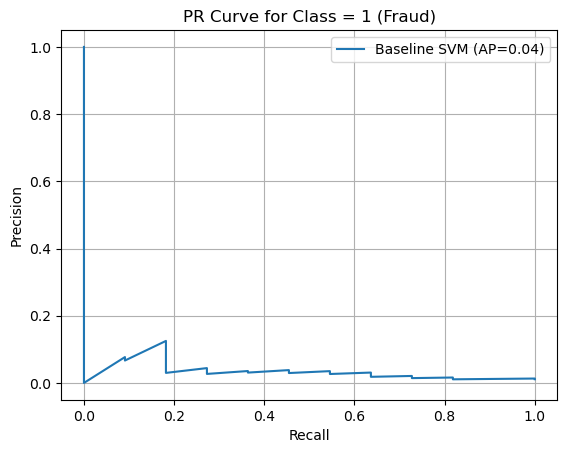

In [31]:
# Train a baseline Polynomial Kernel SVM on the small dataset. This model does not apply any balancing technique
baseline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=2, C=50, gamma=0.1, probability=True))
])
evaluate(baseline, X_train_small, y_train_small, X_test_small, y_test_small, "Baseline SVM")

### Step 6: Add Class Weights 

=== SVM + class_weight ===
              precision    recall  f1-score   support

           0     0.9899    0.9869    0.9884       989
           1     0.0714    0.0909    0.0800        11

    accuracy                         0.9770      1000
   macro avg     0.5306    0.5389    0.5342      1000
weighted avg     0.9798    0.9770    0.9784      1000



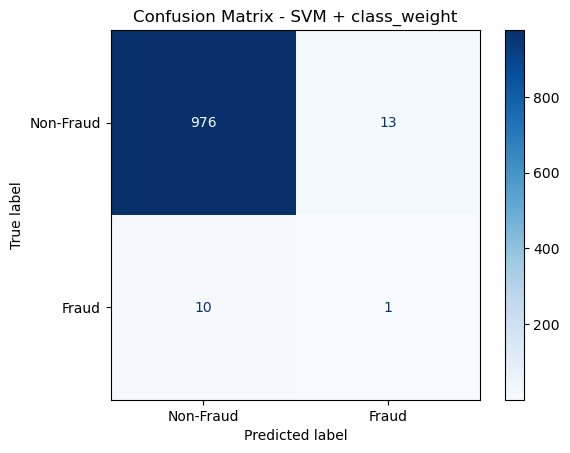

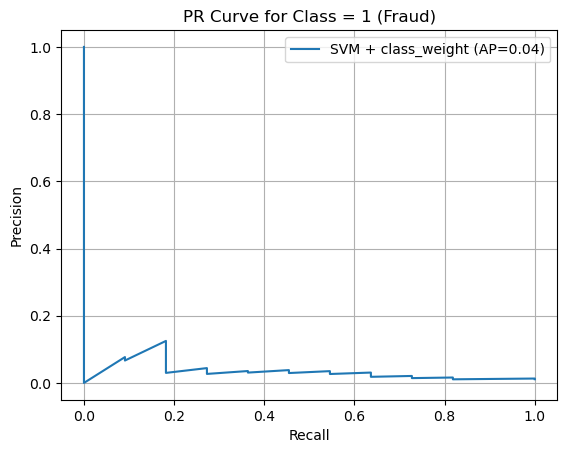

In [32]:
# Use class_weight='balanced' in SVM to penalize the model
balanced = ImbPipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=2, C=50, gamma=0.1, class_weight='balanced', probability=True))
])
evaluate(balanced, X_train_small, y_train_small, X_test_small, y_test_small, "SVM + class_weight")

### Step 7: Add SMOTE

=== SVM + SMOTE ===
              precision    recall  f1-score   support

           0     0.9899    0.9889    0.9894       989
           1     0.0833    0.0909    0.0870        11

    accuracy                         0.9790      1000
   macro avg     0.5366    0.5399    0.5382      1000
weighted avg     0.9799    0.9790    0.9795      1000



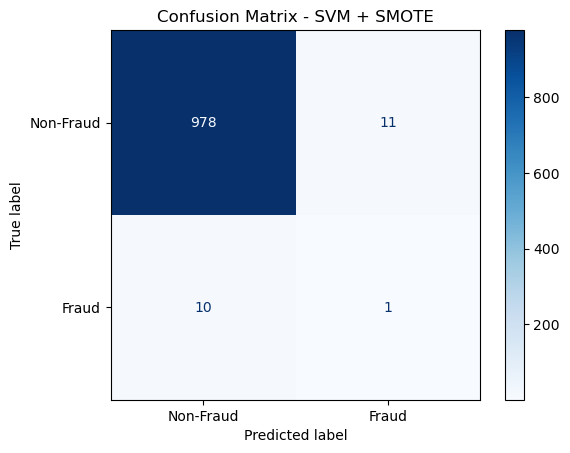

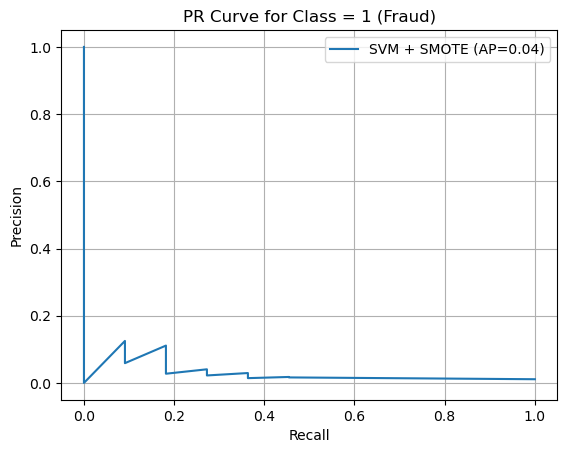

In [33]:
# Apply SMOTE to balance the training set
smote_model = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=2, C=50, gamma=0.1, class_weight='balanced', probability=True))
])
evaluate(smote_model, X_train_small, y_train_small, X_test_small, y_test_small, "SVM + SMOTE")

### Step 8: Add ADASYN

=== SVM + ADASYN ===
              precision    recall  f1-score   support

           0     0.9899    0.9899    0.9899       989
           1     0.0909    0.0909    0.0909        11

    accuracy                         0.9800      1000
   macro avg     0.5404    0.5404    0.5404      1000
weighted avg     0.9800    0.9800    0.9800      1000



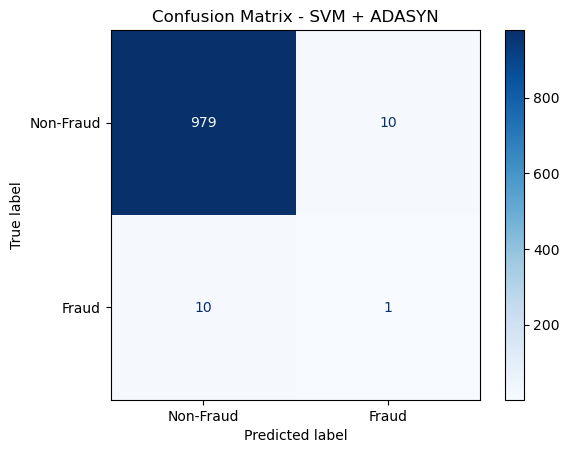

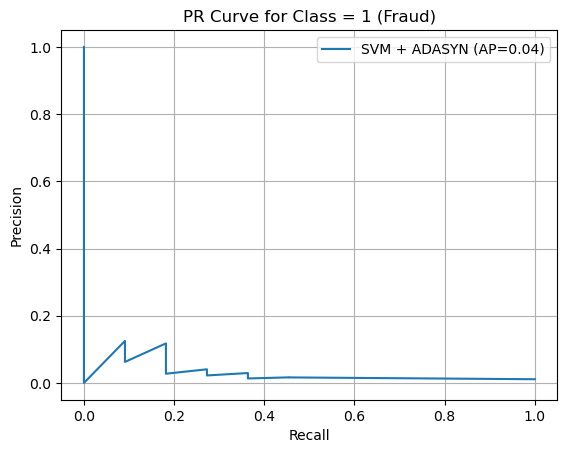

In [34]:
# Use ADASYN (Adaptive Synthetic Sampling) to generate synthetic fraud samples with more focus on harder-to-learn regions
adasyn_model = ImbPipeline([
    ('adasyn', ADASYN(random_state=42)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=2, C=50, gamma=0.1, class_weight='balanced', probability=True))
])
evaluate(adasyn_model, X_train_small, y_train_small, X_test_small, y_test_small, "SVM + ADASYN")


### Step 9: Fraud Recall Comparison Across Models 

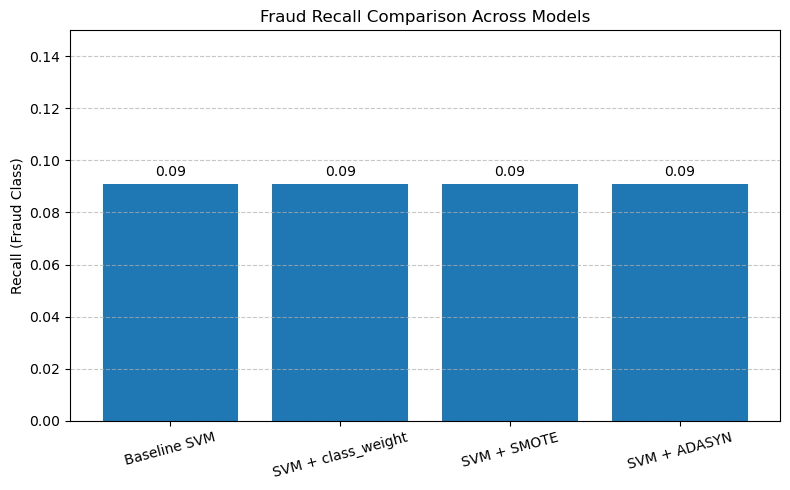

In [35]:
# Model name and corresponding fraud recall value
models = ['Baseline SVM', 'SVM + class_weight', 'SVM + SMOTE', 'SVM + ADASYN']
recalls = [0.0909, 0.0909, 0.0909, 0.0909]  

# Create a bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(models, recalls)
plt.title('Fraud Recall Comparison Across Models')
plt.ylabel('Recall (Fraud Class)')
plt.ylim(0, 0.15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels to each column
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.002, f'{height:.2f}', ha='center', va='bottom')

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

All four models report a fraud recall of ~0.09 (9%), indicating no significant improvement from the class balancing techniques applied.

### Step 10: Validate with 10k Test Set 

=== ADASYN (10k Test Set) ===
              precision    recall  f1-score   support

           0     0.9898    0.9837    0.9868      9893
           1     0.0417    0.0654    0.0509       107

    accuracy                         0.9739     10000
   macro avg     0.5157    0.5246    0.5188     10000
weighted avg     0.9797    0.9739    0.9768     10000



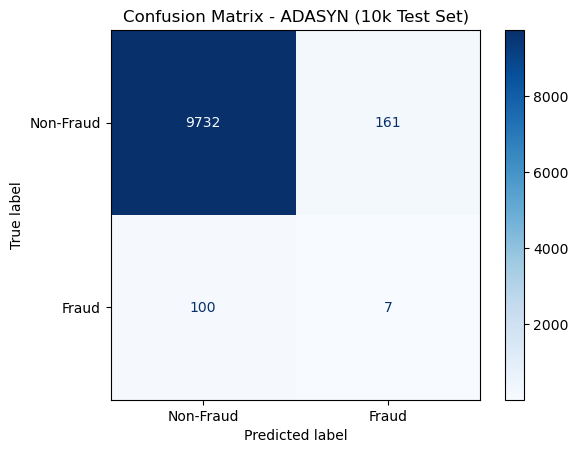

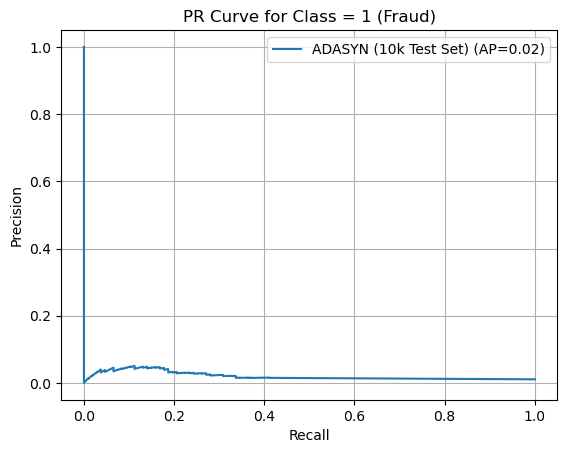

In [36]:
# Expand the test set to 10k and verify whether the ADASYN results are consistent

# Draw 10,000 samples from the full X_test_full
X_test_large, _, y_test_large, _ = train_test_split(
    X_test_full, y_test_full, train_size=10000, stratify=y_test_full, random_state=42)

# Evaluate ADASYN using the same training set (4000) + a larger test set (10000)
evaluate(adasyn_model, X_train_small, y_train_small, X_test_large, y_test_large, "ADASYN (10k Test Set)")

### Final Summary

In this project, we used several polynomial SVM models to detect fraud in a highly imbalanced dataset.  
We tested different methods to handle the imbalance problem, including `class_weight='balanced'`, SMOTE, and ADASYN.

However, all the models achieved similar recall results for the fraud class (around **9%**), and the precision remained very low.  
We also used a larger test set with 10,000 samples to check the ADASYN model, but the result still did not improve.

This shows that **polynomial SVM may not be a good choice** for this kind of imbalanced data.